# TABLE EMP_ACTION 

In [1]:
#========================================================================================
# import needed libraries/packages 
#
# Note:  we use boto3 which is a Python SDK for AWS.  It allows you to create,
# configure and manage AWS resources from your Python scripts.  
#========================================================================================
import os
import pandas as pd
from io import StringIO # python3; python2: BytesIO 
import boto3
import numpy as np

In [11]:
#========================================================================================
# Identify the  S3 bucket, and the file(s) to download
#========================================================================================
# bucket_name = 's3://sagemaker-qut/'
file_path  = '/Users/asifrezachowdhury/Library/CloudStorage/OneDrive-Personal/Academics/QUT Academics/Semester 2-2/IFN711 Project/Project/data/'

# file_action= file_path + "EMP_ACTIONS.CSV" 
# data = "{}{}".format(bucket_name,file_action)
data = file_path + "EMP_ACTIONS.CSV" 
action_df = pd.read_csv(data)
#action_df 

/var/folders/fs/5rddcscd7218ydcqdwg75vq00000gn/T/ipykernel_29132/1779061230.py:11: DtypeWarning: Columns (3,21,50) have mixed types. Specify dtype option on import or set low_memory=False.
  action_df = pd.read_csv(data)


In [12]:
# Check table collumn datatype

print(action_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20170 entries, 0 to 20169
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EMPLOYEE_GID       20170 non-null  object 
 1   EMPLOYEE_RID       20170 non-null  object 
 2   CALDAY             20170 non-null  int64  
 3   ACTIONTYPE         20170 non-null  object 
 4   ACTIONREAS         15277 non-null  float64
 5   EMPLSTATUS         20170 non-null  int64  
 6   _BIC_ACTNCOUNT     20170 non-null  int64  
 7   _BIC_ACTNHIRE      20170 non-null  int64  
 8   _BIC_ACTNTERMN     20170 non-null  int64  
 9   _BIC_WEEK          20170 non-null  int64  
 10  WEEKDAY1           20170 non-null  int64  
 11  CALMONTH           20170 non-null  int64  
 12  CALMONTH2          20170 non-null  int64  
 13  CALQUART1          20170 non-null  int64  
 14  CALQUARTER         20170 non-null  int64  
 15  CALWEEK            20170 non-null  int64  
 16  CALYEAR            201

In [13]:
# Now we will  get specific col based on understand about business domain for resignation model
sp_cols = ["ACTIONTYPE", "ACTIONREAS", "AGE", "BUS_AREA", "_BIC_TERMDATE"]
action_df = action_df[sp_cols]

In [14]:
print(action_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20170 entries, 0 to 20169
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ACTIONTYPE     20170 non-null  object 
 1   ACTIONREAS     15277 non-null  float64
 2   AGE            20170 non-null  int64  
 3   BUS_AREA       20168 non-null  object 
 4   _BIC_TERMDATE  20170 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 788.0+ KB
None


In [15]:
# Checking for '?' as 'Invalid/Unknown'
def check_invalid_value(invalid_value):
    for col in action_df.columns:
        if action_df[col].dtype == object:
            print(col,action_df[col][action_df[col] == invalid_value].count())

In [16]:
check_invalid_value('null')
check_invalid_value('')
check_invalid_value('invalid')
check_invalid_value(np.NaN)

ACTIONTYPE 0
BUS_AREA 0
ACTIONTYPE 0
BUS_AREA 0
ACTIONTYPE 0
BUS_AREA 0
ACTIONTYPE 0
BUS_AREA 0


# Pre-processing dataset

In [17]:
# Get ACTIONTYPE as 9 and 10 only
# Action type 9 and 10 should both be considered termination .
# 9 is through SAP 10 is manual.

#action_df_filtered= action_df.loc[(action_df['ACTIONTYPE'] == 9) | (action_df['ACTIONTYPE'] == 10) & (action_df['ACTIONREAS'] == 1.0)]

In [18]:
action_df_filtered = action_df

In [19]:
# Check null value at ACTIONREAS col
action_df_filtered['ACTIONREAS'].isnull().values.any()
action_df_filtered['ACTIONREAS'].isnull().sum()

4893

In [20]:
mode = action_df_filtered['ACTIONREAS'].mode().values[0]
# replace NaN by mode value for string datatype
action_df_filtered['ACTIONREAS'] = action_df_filtered['ACTIONREAS'].replace({np.NaN: mode})

In [21]:
# ACTIONREAS variable should be in int64 data type. Before converting to integer, this variable is rounded to become integer.
action_df_filtered['ACTIONREAS'] = action_df_filtered['ACTIONREAS'].apply(np.ceil)

In [22]:
# By obervation, we sound in ACTIONTYPE have 'S1', 'S2'  as categorical datatype
# So we will replace 'S1' => 98
# 'S2' => 99 
# For integer converting purpose later
action_df_filtered['ACTIONTYPE'] = action_df_filtered['ACTIONTYPE'].replace({'S1': 98})
action_df_filtered['ACTIONTYPE'] = action_df_filtered['ACTIONTYPE'].replace({'S2': 99})

In [23]:
print('********* Check data type BEFORE correcting *********')
print('***ACTIONREAS***')
print(action_df_filtered.ACTIONREAS.dtype)
print('***ACTIONTYPE***')
print(action_df_filtered.ACTIONTYPE.dtype)

********* Check data type BEFORE correcting *********
***ACTIONREAS***
float64
***ACTIONTYPE***
object


In [24]:
action_df_filtered["ACTIONREAS"] = action_df_filtered["ACTIONREAS"].astype('int64')
action_df_filtered["ACTIONTYPE"] = action_df_filtered["ACTIONTYPE"].astype('int64')

In [25]:
print(action_df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20170 entries, 0 to 20169
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ACTIONTYPE     20170 non-null  int64 
 1   ACTIONREAS     20170 non-null  int64 
 2   AGE            20170 non-null  int64 
 3   BUS_AREA       20168 non-null  object
 4   _BIC_TERMDATE  20170 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 788.0+ KB
None


# Explore data

In [26]:
# To ignore any future warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
action_df_filtered_ex = action_df_filtered.select_dtypes(include=[np.number])

In [28]:
def check_describe(data_frame, col_name):
    print("\n===============================")
    print("Check Describe of: " + col_name)
    print("===============================")
    print(data_frame[col_name].describe())
    
    print("\n===============================")
    print("Check Mode of: " + col_name)
    print("===============================")
    print(data_frame[col_name].mode())

In [29]:
check_describe(action_df_filtered, 'ACTIONREAS')
check_describe(action_df_filtered, 'ACTIONTYPE')


Check Describe of: ACTIONREAS
count    20170.000000
mean         2.211750
std          2.543261
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         99.000000
Name: ACTIONREAS, dtype: float64

Check Mode of: ACTIONREAS
0    2
Name: ACTIONREAS, dtype: int64

Check Describe of: ACTIONTYPE
count    20170.000000
mean        16.203322
std         21.992996
min          1.000000
25%          4.000000
50%          9.000000
75%         16.000000
max         99.000000
Name: ACTIONTYPE, dtype: float64

Check Mode of: ACTIONTYPE
0    16
Name: ACTIONTYPE, dtype: int64


Skewness
ACTIONREAS
=> Mode (1) < Median (1) < Mean (9)
=> Skewness positive  Zero Skewness so ACTIONTYPE is normal distribution

ACTIONTYPE
=> Median (9) < Mode (16)  < Mean (16.2)
=> Skewness positive

In [33]:
# We need to understand more about skewness in ACTIONREAS
def draw_plot(col_name):
    dg = sns.distplot(action_df_filtered[col_name])
    plt.show()

***ACTIONTYPE***


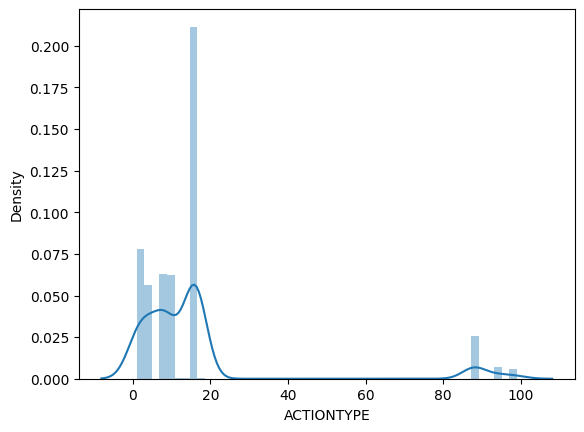

In [34]:
print("***ACTIONTYPE***")
draw_plot('ACTIONTYPE')

In [35]:
action_df_filtered.skew()

TypeError: could not convert string to float: 'BNE'

In [36]:
# action_df_log = np.log(action_df_filtered['ACTIONREAS'])
# action_df_log.skew()

In [37]:
def remove_outliers_positive_skewness(data):
    """
    This function removes outliers from a dataset that exhibits positive skewness.

    Args:
    data (array-like): The dataset to remove outliers from.

    Returns:
    array-like: The cleaned dataset with outliers removed.
    """

    # Calculate the skewness of the dataset
    #skewness = np.skew(data)

    # Calculate the interquartile range (IQR) of the dataset
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1

    # Calculate the upper bound of the data
    upper_bound = q3 + (1.5 * iqr)

    # Remove the outliers from the dataset
    cleaned_data = data[data <= upper_bound]

    return cleaned_data

In [38]:
actionreas_clean =  remove_outliers_positive_skewness(action_df_filtered['ACTIONTYPE'])

In [39]:
actionreas_clean

30       4
31       4
32       2
33       4
34       4
        ..
20165    9
20166    9
20167    9
20168    9
20169    9
Name: ACTIONTYPE, Length: 18654, dtype: int64

In [40]:
action_df_filtered['ACTIONTYPE'] = actionreas_clean

# After removing outliner now dataset has some NaN values and that need to replace by mode values to keep data normal distribution
# select ACTIONREAS mode value by getting the first element from return list
mode = action_df_filtered['ACTIONTYPE'].mode().values[0]
# replace NaN by mode value for string datatype
action_df_filtered['ACTIONTYPE'] = action_df_filtered['ACTIONTYPE'].replace({np.NaN: mode})

action_df_filtered['ACTIONTYPE'] = action_df_filtered['ACTIONTYPE'].apply(np.ceil)
action_df_filtered["ACTIONTYPE"] = action_df_filtered["ACTIONTYPE"].astype('int64')

In [41]:
# Check null value at ACTIONTYPE col
action_df_filtered['ACTIONTYPE'].isnull().values.any()
action_df_filtered['ACTIONTYPE'].isnull().sum()

0

In [42]:
print(action_df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20170 entries, 0 to 20169
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ACTIONTYPE     20170 non-null  int64 
 1   ACTIONREAS     20170 non-null  int64 
 2   AGE            20170 non-null  int64 
 3   BUS_AREA       20168 non-null  object
 4   _BIC_TERMDATE  20170 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 788.0+ KB
None


In [43]:
action_df_filtered

,ACTIONTYPE,ACTIONREAS,AGE,BUS_AREA,_BIC_TERMDATE
0,16,2,42,BNE,0
1,16,2,37,HF,0
2,16,2,66,ADL,0
3,16,2,50,BNE,0
4,16,2,46,BNE,0
...,...,...,...,...,...
20165,9,1,32,JIN,20230210
20166,9,1,51,ADL,20230219
20167,9,1,51,ECH,20230222
20168,9,1,38,HF,20230302


***ACTIONTYPE***


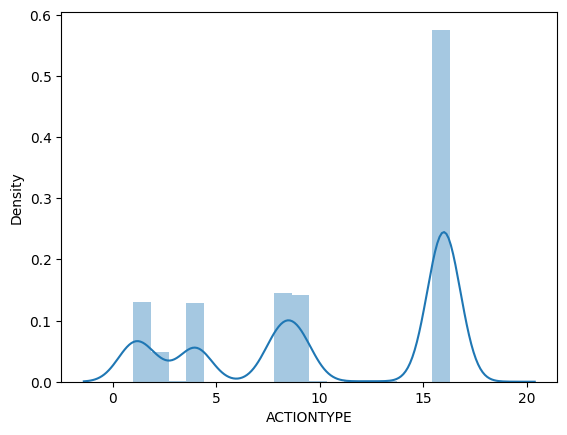

In [44]:
print("***ACTIONTYPE***")
draw_plot('ACTIONTYPE')

### Create new col IS_VOLUNTARY with flag 0 or 1 for Voluntary Resignations  

In [45]:
# define a function to map voluntary resignation
# action type 9 or 10 and action reason 01 => 1
# else =>  0

def map_values(action_type, action_reason):
    if ((action_type == 9 or action_type == 10) and action_reason == 1):
        return 1
    else:
        return 0


In [46]:
# apply the function to create a new column based on old_column
action_df_filtered['IS_VOLUNTARY'] = action_df_filtered.apply(lambda row: map_values(row['ACTIONTYPE'], row['ACTIONREAS']), axis=1)

# display the modified dataframe
print(action_df_filtered)


       ACTIONTYPE  ACTIONREAS  AGE BUS_AREA  _BIC_TERMDATE  IS_VOLUNTARY
0              16           2   42      BNE              0             0
1              16           2   37       HF              0             0
2              16           2   66      ADL              0             0
3              16           2   50      BNE              0             0
4              16           2   46      BNE              0             0
...           ...         ...  ...      ...            ...           ...
20165           9           1   32      JIN       20230210             1
20166           9           1   51      ADL       20230219             1
20167           9           1   51      ECH       20230222             1
20168           9           1   38       HF       20230302             1
20169           9           1   36      ROW       20230310             1

[20170 rows x 6 columns]


# Building some correlation model to understand about dataset

In [47]:
# Identify the highly correlated variable pairs and elaborate on how to treat these 
# variables in the mining process in such a case.
# Select only numeric data type
corr = action_df_filtered.corr()
f = plt.figure(figsize=(15, 15))
plt.matshow(action_df_filtered.corr(), fignum=f.number)
plt.xticks(range(action_df_filtered.select_dtypes(['int64']).shape[1]), action_df_filtered.select_dtypes(['int64']).columns, fontsize=14, rotation=90)
plt.yticks(range(action_df_filtered.select_dtypes(['int64']).shape[1]), action_df_filtered.select_dtypes(['int64']).columns, fontsize=14)
im = plt.imshow(corr, cmap='coolwarm')
cb = plt.colorbar(im)
cb.ax.tick_params(labelsize=14)
plt.show()
#plt.title('Correlation Matrix', fontsize=16);

ValueError: could not convert string to float: 'BNE'

In [48]:
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

NameError: name 'corr' is not defined